In [274]:
import sys
sys.path.append('../scripts') 

import numpy as np
import pandas as pd
import qutip
from qutip_tools import *

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  
from ast import literal_eval

In [275]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 20

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../plots/perturbative/"
data_route = "../data/sims/L=21/"


# Functions

In [276]:
def kth_diag_indices(a, k):
    # negative numbers go below the diagonal, 0 is the main diagonal and positive nums go above
    rows, cols = np.diag_indices_from(a)
    if k < 0:
        return rows[-k:], cols[:k]
    elif k > 0:
        return rows[:-k], cols[k:]
    else:
        return rows, cols
    
# Find index of the closest value
def find_nearest(arr, target):
    idx = np.abs(arr - target).argmin()
    return arr[idx], idx

def mag_sort(en_array, vec_array):
    # sorts the energies and eigenvectors by energy magnitude
    sort_idx = np.argsort(en_array)
    en_array = en_array[sort_idx]
    vec_array = vec_array[:,sort_idx]

    return en_array, vec_array
    

def xhi(K,P, B):
    # the matrix elements for perturbation
    return np.sin(B*P+P)*np.sin(B*K) + np.sin(B*K+K)*np.sin(B*P)

In [277]:
def sort_by_projection(energy_list,eigen_list, Proj):
    # sorts the eigenvectors from numpy diagonalize into bands by their projection onto Proj
    P_elements = []
    # separate into bands accordin to their projection
    for i in range(0,len(energy_list)):
        # for plus states
        ev = eigen_list[:,i]
        ev_proj = np.matmul(Proj,ev)
        # here we round off to nearest integer only for the separation
        P_elements.append(round(np.dot(np.conj(ev), ev_proj)))
        
    P_elements = np.asarray(P_elements)
    
    # the symmetric states will be those with 1
    p_sort_idx = np.argwhere(P_elements==1)[:,0]
    
    # the antisymmetric states will be those with 0
    m_sort_idx = np.argwhere(P_elements==0)[:,0]

    return m_sort_idx, p_sort_idx

def separate_band(eigen_array, energy_array):
    # since linalg spits out eigenvalues is some weird order se
    # organize them in the proper band corresponding to the qubit states
    band_list = []
    index_list = []
    for target_ in energy_array:
        closest, index_c = find_nearest(eigen_array, target_)
        band_list.append(closest)
        index_list.append(index_c)
    
    return np.asarray(band_list), index_list
    

def get_projection_colors(state_list, Proj):
    # get the colors for the band in staet list
    # acording to the matrix element of the projection Proj
    colors_ = []
    # calculate the colors
    for i in range(0,np.shape(state_list)[1]):
        # for plus states
        ev = state_list[:,i]
        ev_proj = np.matmul(Proj,ev)
        colors_.append(np.dot(np.conj(ev), ev_proj))
        
    return np.asarray(colors_)


In [278]:
def separate_by_proximity(numeric_energy, numeric_states):
    # sorts numeric energy in accordance to the proximity to the two decoupled bands em0 ep0
    sort_idx = np.argsort(numeric_energy)
    sorted_energies = numeric_energy[sort_idx]
    sorted_states = numeric_states[:,sort_idx]

    marker_list = []

    ep_copy = ep0
    em_copy = em0
    
    for i in range(0, len(sorted_energies)):
        # find the closest state in the plus band
        ep_close, p_idx = find_nearest(ep_copy, sorted_energies[i])
        # find the closest state in the minus band
        em_close, m_idx = find_nearest(em_copy, sorted_energies[i])
        
        # get the difference and sort according to which is the smallest
        dif_plus = abs(sorted_energies[i] - ep_close)
        dif_minus = abs(sorted_energies[i] - em_close)

        # accept in the minus band
        if dif_plus>=dif_minus:
            marker_list.append(0)
            # remove to avoid double counting
            # np.delete(ep_copy, p_idx)
        else:
            marker_list.append(1)
            # np.delete(em_copy, m_idx)
            
    marker_list = np.asarray(marker_list)
    
    idx = np.argwhere(marker_list==1)[:,0]
    plus_energies = sorted_energies[idx]
    plus_states = sorted_states[:,idx]

    idx = np.argwhere(marker_list==0)[:,0]
    minus_energies = sorted_energies[idx]
    minus_states = sorted_states[:,idx]

    return minus_energies, minus_states, plus_energies, plus_states, 

In [279]:

def plot_2_bands(Em_correct, Ep_correct, Energies_m, Energies_p, Colors_m, Colors_p, Figuresize=(13,5)):
    # Em_correct, Ep_correct are the perturbatively corrected energies 
    # Energies_m, Energies_p are the numpy eigenvalues
    fig, ax = plt.subplots(1,2, figsize=Figuresize)
    c_norm = (-0.2,1.2)

    ax[0].plot(k_single_band, Em_correct, c= "red")
    ax[0].plot(k_single_band, Ep_correct, c= "blue")
    # zoomed in 
    ax[1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    
    # Diagonalized 
    sns.scatterplot(x=k_single_band, y=Energies_p, hue= Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0])
    
    img = sns.scatterplot(x=k_single_band, y=Energies_m, hue= Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0])
    
    # zoomed
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_p[cut1:cut2], hue= Colors_p[cut1:cut2], hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[1])
    
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_m[cut1:cut2], hue= Colors_m[cut1:cut2], hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[1],)

    # Get the scatter object and attach colorbar
    norm = plt.Normalize(c_norm[0], c_norm[1])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])  # Required for ScalarMappable with no mappable object
    plt.colorbar(sm, ax=ax)
    
    # write x axis in units of pi
    ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    
    ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    ax[0].set_xlabel(r"$k$")
    ax[0].set_ylabel(r"$E$")
    ax[1].set_xlabel(r"$k$")

    return ax

In [280]:
def plot_2_bands_2sorts(Em_correct, Ep_correct, Energies_m, Energies_p, 
                        Energies_prox_m, Energies_prox_p,Colors_m, Colors_p, 
                        Over_Colors_m, Over_Colors_p, Figuresize=(12,8)):
    # Em_correct, Ep_correct are the perturbatively corrected energies for the proximity and projection sorting
    # Energies_m, Energies_p are the numpy eigenvalues
    fig, ax = plt.subplots(2,2, figsize=Figuresize)

    # -------- For the Projection sorting-------------

    ax[0,0].plot(k_single_band, Em_correct, c= "red")
    ax[0,0].plot(k_single_band, Ep_correct, c= "blue")
    sns.scatterplot(x=k_single_band, y=Energies_p, hue= Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0,0])
    img = sns.scatterplot(x=k_single_band, y=Energies_m, hue= Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0,0])
    
    # zoomed in 
    ax[0,1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[0,1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_p[cut1:cut2], hue= Colors_p[cut1:cut2], hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[0,1])
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_m[cut1:cut2], hue= Colors_m[cut1:cut2], hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[0,1],)
    
    # -------- For the overlap sorting-------------
    ax[1,0].plot(k_single_band, Em_correct, c= "red")
    ax[1,0].plot(k_single_band, Ep_correct, c= "blue")
    sns.scatterplot(x=k_single_band, y=Energies_prox_p, hue= Over_Colors_p, hue_norm= c_norm, palette="RdBu", 
                    edgecolor="black", legend=None,ax=ax[1,0])
    img = sns.scatterplot(x=k_single_band, y=Energies_prox_m, hue= Over_Colors_m, hue_norm= c_norm, palette="RdBu" , 
                    edgecolor="black", legend=None,ax=ax[1,0])
    
    # zoomed in 
    ax[1,1].plot(k_single_band[cut1:cut2], Em_correct[cut1:cut2], c= "red")
    ax[1,1].plot(k_single_band[cut1:cut2], Ep_correct[cut1:cut2], c= "blue")
    sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_prox_p[cut1:cut2], hue= Over_Colors_p[cut1:cut2], hue_norm= c_norm,
                    palette="RdBu", edgecolor="black", legend=None,ax=ax[1,1])
    img = sns.scatterplot(x=k_single_band[cut1:cut2], y=Energies_prox_m[cut1:cut2], hue= Over_Colors_m[cut1:cut2], hue_norm= c_norm, 
                          palette="RdBu" , edgecolor="black", legend=None,ax=ax[1,1],)
    
    # ------ aesthetical things ---------------
    # Get the scatter object and attach colorbar to one of the plots
    norm = plt.Normalize(c_norm[0], c_norm[1])
    sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
    sm.set_array([])  # Required for ScalarMappable with no mappable object
    plt.colorbar(sm, ax=ax)
    
    # write x axis in units of pi
    ax[0,0].set_title(r"Sorted by Projection")
    ax[0,0].set_xticks([],[])
    ax[0,0].set_ylabel(r"$E$")
    ax[0,1].set_xticks([],[])
    ax[1,0].set_title(r"Sorted by Overlaps")
    ax[1,0].set_xlabel(r"$k$")
    ax[1,0].set_ylabel(r"$E$")
    ax[1,1].set_xlabel(r"$k$")

    ax[1,0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))
    
    ax[1,1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                                 r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                                 else '0'))

    return ax 


# Perturbations to the energy

we compared to the exact diagonalization

## Initialize the System

In [358]:
L_qpc = 60
L = L_qpc + 2
Omega = 0.7
t=0.06
J_prime = 1
bond_index = int(L_qpc/2)
J = np.ones(L_qpc) # QPC hopping
J[bond_index] = J_prime  

print(t)
# create the fermion operator list
np.pi/(L_qpc+1)

0.06


0.05150151891130808

Bond at:  60


<Axes: >

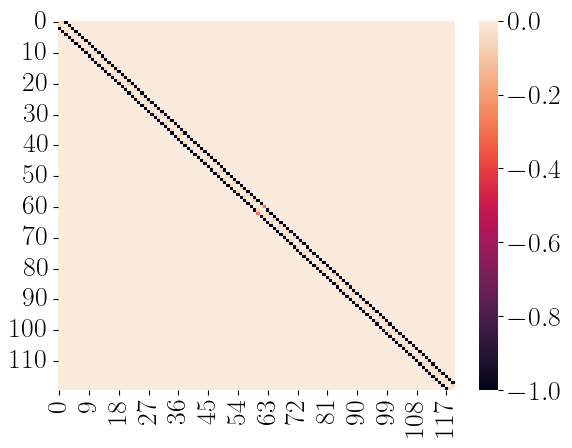

In [359]:
H_matrix = np.zeros((2*L_qpc,2*L_qpc))
# fill in the dd hopping only in odd diagonals
d_indices= kth_diag_indices(H_matrix,1)
H_matrix[d_indices] = -t

# fill in the QPC hopping
d_indices= kth_diag_indices(H_matrix,2)
H_matrix[d_indices] = -J[0]

# when qpc and qubit hop a the same time there is no contribution
d_indices= kth_diag_indices(H_matrix,1)
odd_inds = (d_indices[0][1::2], d_indices[1][1::2])
H_matrix[odd_inds] = 0

# save the free hamiltonian for later use
Hdeco = H_matrix.copy()

# Fill in the interaction at the bond
H_matrix[2*bond_index,2*(bond_index+1)] = H_matrix[2*bond_index,2*(bond_index+1)]+ Omega

# Now the elemets below the diagonal
for i in range(0,2*L_qpc):
    for j in range(i + 1, 2*L_qpc):
        H_matrix[j, i] = H_matrix[i, j]
        Hdeco[j, i] = Hdeco[i, j]

print("Bond at: ", 2*bond_index)
sns.heatmap(H_matrix)

In [360]:
# Calculate the energies and eigenvectors
energies, eigen_vecs = np.linalg.eig(H_matrix)
# normalize
eigen_vecs = eigen_vecs/ np.linalg.norm(eigen_vecs, axis=0)

# calculate the decoupled system analytic eigenenergies (zeroth order correction)
k_single_band = np.arange(1,L_qpc+1)*np.pi/(L_qpc+1)
em0 = -2*J[0]*np.cos(k_single_band) - t 
ep0 = -2*J[0]*np.cos(k_single_band) + t 

# find the momenta that we are mostly interested in (far from the edges of the brillouin zone)
_, cut1 = find_nearest(k_single_band, 0.2*np.pi)
_, cut2 = find_nearest(k_single_band, 0.8*np.pi)

np.linspace(0.5*np.pi,1.4*np.pi,5)

array([1.57079633, 2.27765467, 2.98451302, 3.69137137, 4.39822972])

## Sorting into bands
Here we expect two bands, however we have to be carefull because **linalg spits the eigenvectors and states all mixed up instead of in neat bands**. So what we have to do is construct a projection operator and apply it to the eigenstates from numpy. Their values will be either 1 or 0 and with that we will be able to sort them into the proper symmetry bands

### Sorting by Projection

In [361]:
# build the projection opeartor to the qubit-symmetric sector of the hilbert space
Id_qpc = np.eye(L_qpc)
plusket = np.asarray([1/np.sqrt(2),1/np.sqrt(2)])
p_ketbra = np.outer(plusket,plusket)
Psym = np.eye(2*L_qpc) - np.kron(Id_qpc, p_ketbra) # tensor product


In [362]:
mindices, pindices = sort_by_projection(energies,eigen_vecs, Psym)

# minus band
energies_m = energies[mindices]
states_m = eigen_vecs[:,mindices]
# sort by magnitude
energies_m, states_m = mag_sort(energies_m, states_m)

# plus band
energies_p = energies[pindices]
states_p = eigen_vecs[:,pindices]
energies_p, states_p = mag_sort(energies_p, states_p)


# get the colors for each band 
colors_p = get_projection_colors(states_p, Psym)
colors_m = get_projection_colors(states_m, Psym)

### sorting by proximity

Separating with proximity to decoupled energies: **This will not work because sometimes I have eigenvaleus that are very far away annd they wont get assigned at all. Try this one out:**

https://scicomp.stackexchange.com/questions/10708/sorting-eigenvalues-by-the-dominant-contribution 

In [363]:

proximity_m, prox_state_m, proximity_p, prox_state_p = separate_by_proximity(energies, eigen_vecs)

pro_colors_p = get_projection_colors(prox_state_p, Psym)
pro_colors_m = get_projection_colors(prox_state_m, Psym)


### Sorting by Overlap matrix

So the idea is that we grab the eigenvectors of the free system calculated with python and calculate the overlap with those of the coupled system. Coupled vector with the largest overlap will correspond to the $k$ of the free system. Since gor the free system we can perfectly find each $k$ we can therefore also sort the interacting one from that.



In [364]:
# Calculate the energies and eigenvectors
free_energies, free_eigen_vecs = np.linalg.eig(Hdeco)
# normalize
free_eigen_vecs = free_eigen_vecs/ np.linalg.norm(free_eigen_vecs, axis=0)


Text(0.5, 1.0, 'Overlap Matrix')

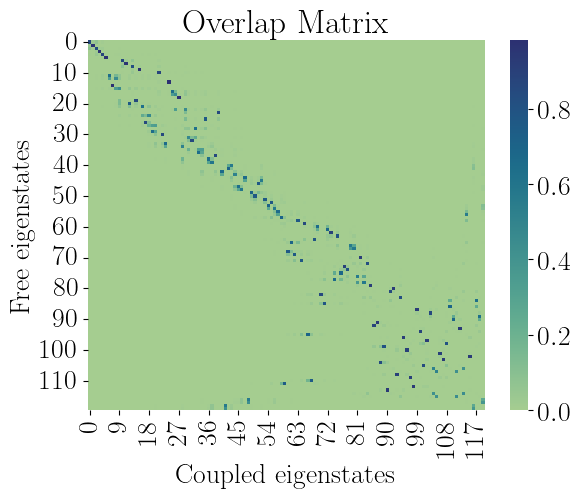

In [365]:
# calculate the overlaps between the eigenvectors of H0 and
sorted_indices = []
over_matrix = np.zeros((len(energies),len(energies)))
for i in range(0,len(energies)):
    for j in range(0,len(energies)):
        overlap = (np.dot(free_eigen_vecs[:,i].conj(), eigen_vecs[:,j]))**2
        over_matrix[i,j] = overlap
    # now in the current ith row grab the j index of the maximum overlap
    sorted_indices.append(np.argmax(over_matrix[i,:]))
        
sns.heatmap(over_matrix,cmap="crest")
plt.xlabel("Coupled eigenstates")
plt.ylabel("Free eigenstates")
plt.title("Overlap Matrix")

In [366]:
# now sort the freee case into bands according to projection
mindices, pindices = sort_by_projection(free_energies,free_eigen_vecs, Psym)

# minus band
free_energies_m = free_energies[mindices]
free_states_m = free_eigen_vecs[:,mindices]
# sort by magnitude
free_energies_m, free_states_m = mag_sort(free_energies_m, free_states_m)

# plus band
free_energies_p = free_energies[pindices]
free_states_p = free_eigen_vecs[:,pindices]
# sort by magnitude
free_energies_p, free_states_p = mag_sort(free_energies_p, free_states_p)


In [367]:
# now sort the coupled eigenvectors and values according to max overlaps so they match with the free case
sorted_e = energies[sorted_indices]
sorted_vecs = eigen_vecs[:,sorted_indices]

# minus band
over_energies_m = sorted_e[mindices]
over_states_m = sorted_vecs[:,mindices]
# sort by magnitude
over_energies_m, over_states_m = mag_sort(over_energies_m, over_states_m)

# plus band
over_energies_p = sorted_e[pindices]
over_states_p = sorted_vecs[:,pindices]
# sort by magnitude
over_energies_p, over_states_p = mag_sort(over_energies_p, over_states_p)

# get the colors for each band 
over_colors_p = get_projection_colors(over_states_p, Psym)
over_colors_m = get_projection_colors(over_states_m, Psym)


### Comparing the methods

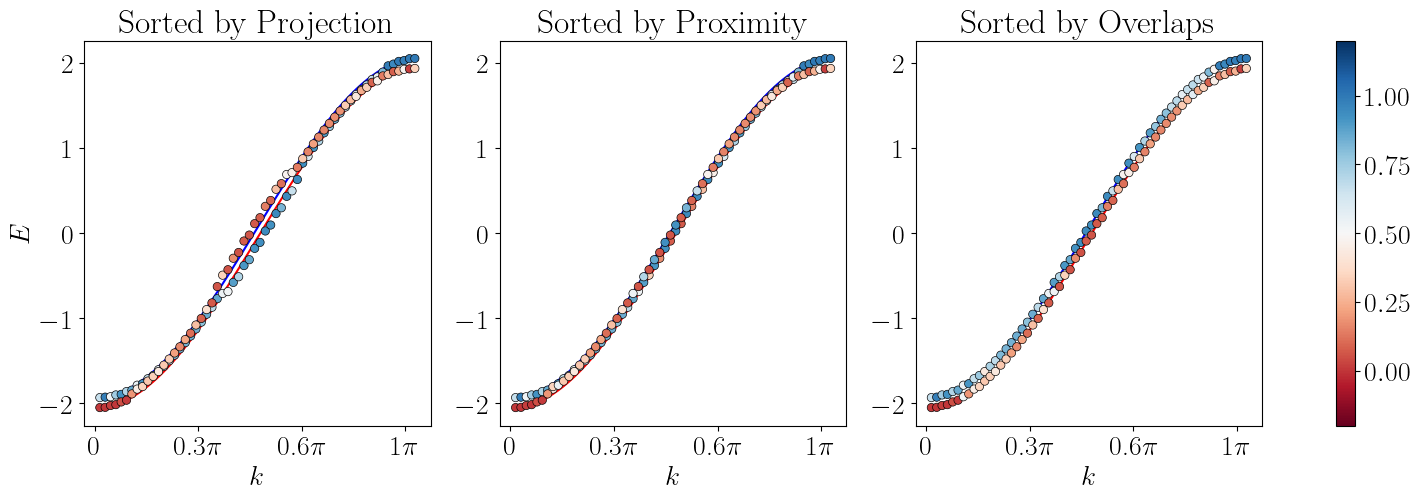

In [368]:
fig, ax = plt.subplots(1,3, figsize=(19,5))

c_norm = (-0.2,1.2)
cmap = "RdBu"
# zeroth order analytic stuff
ax[0].plot(k_single_band, em0, c= "red",zorder=0)
ax[0].plot(k_single_band, ep0, c= "blue",zorder=0)

ax[1].plot(k_single_band, em0, c= "red",zorder=0)
ax[1].plot(k_single_band, ep0, c= "blue",zorder=0)

ax[2].plot(k_single_band, em0, c= "red", zorder=0)
ax[2].plot(k_single_band, ep0, c= "blue",zorder=0)

# projection
sns.scatterplot(x=k_single_band, y=energies_p, hue= colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[0])
sns.scatterplot(x=k_single_band, y=energies_m, hue= colors_m, hue_norm= c_norm, palette=cmap ,
                edgecolor="black", legend=None,ax=ax[0])

# proximity 
sns.scatterplot(x=k_single_band, y=proximity_p, hue= pro_colors_p, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

sns.scatterplot(x=k_single_band, y=proximity_m, hue= pro_colors_m, hue_norm= c_norm, palette=cmap, 
                edgecolor="black", legend=None,ax=ax[1])

# overlaps
sns.scatterplot(x=k_single_band, y=over_energies_p, hue= over_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax[2])

img = sns.scatterplot(x=k_single_band, y=over_energies_m, hue= over_colors_m, palette=cmap ,hue_norm= c_norm,
                edgecolor="black", legend=None,ax=ax[2])

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"$E$")
ax[0].set_title(r"Sorted by Projection")

ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Proximity")

ax[2].set_xlabel(r"$k$")
ax[2].set_title(r"Sorted by Overlaps")


# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object
plt.colorbar(sm, ax=ax)

# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[2].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

# plt.savefig(fig_route+"sorting_compare_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


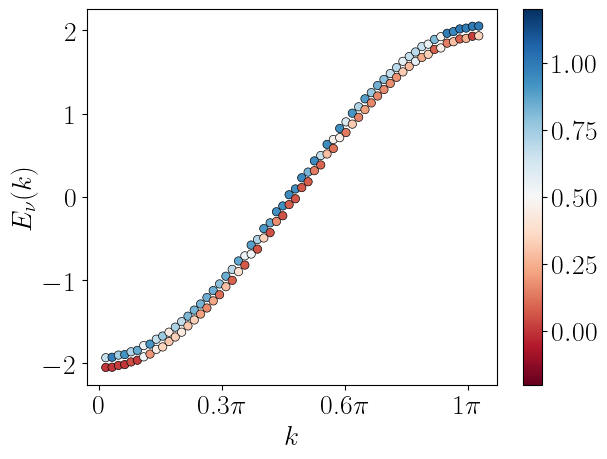

In [369]:
fig, ax = plt.subplots(1,1, figsize=(6.5,5))
# overlaps
sns.scatterplot(x=k_single_band, y=over_energies_p, hue= over_colors_p, hue_norm= c_norm, palette=cmap ,
                edgecolor="black",legend=None, ax=ax)

img = sns.scatterplot(x=k_single_band, y=over_energies_m, hue= over_colors_m, palette=cmap ,hue_norm= c_norm,
                edgecolor="black", legend=None,ax=ax)

# Get the scatter object and attach colorbar
norm = plt.Normalize(c_norm[0], c_norm[1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for ScalarMappable with no mappable object
plt.colorbar(sm, ax=ax)

ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$E_{\nu}(k)$")

# write x axis in units of pi
ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
plt.tight_layout()
plt.savefig(fig_route+"exact_energies_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


Compare energy gaps wrt the decoiupled case

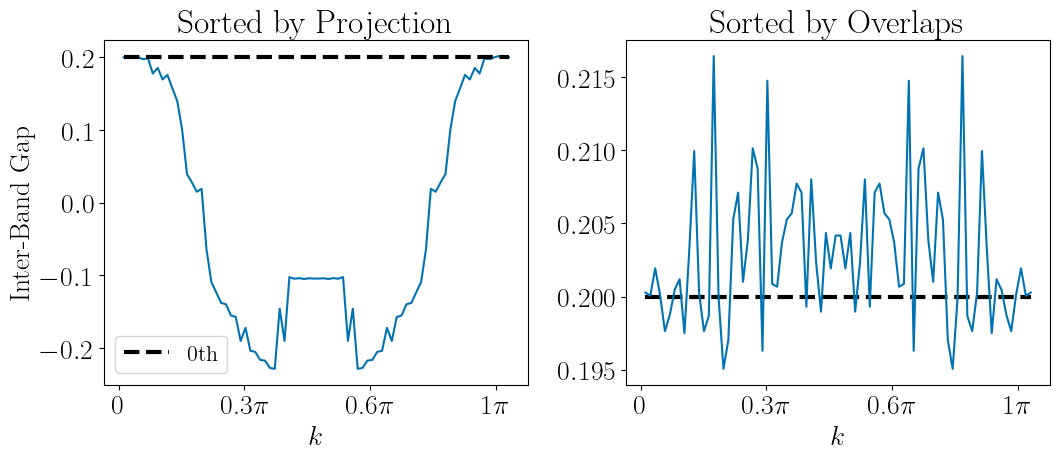

In [305]:
fig, ax = plt.subplots(1,2, figsize=(11,5))


ax[0].plot(k_single_band, energies_p-energies_m)
ax[0].plot(k_single_band, ep0-em0, c="black", linewidth=3, linestyle="dashed", label="0th")

ax[1].plot(k_single_band, ep0-em0, c="black", linewidth=3, linestyle="dashed", label="0th")
ax[1].plot(k_single_band, over_energies_p-over_energies_m)

ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Inter-Band Gap")
ax[0].set_title(r"Sorted by Projection")
ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Overlaps")


# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))
ax[0].legend()
plt.tight_layout()


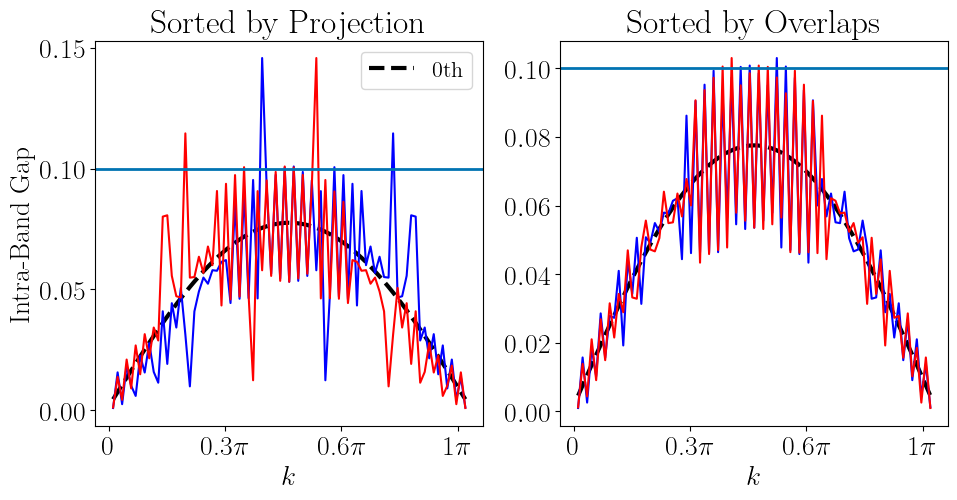

In [306]:
fig, ax = plt.subplots(1,2, figsize=(11,5))
ax[0].plot(k_single_band[:-1], np.diff(ep0) , c="black",linewidth=3, linestyle="dashed",label="0th")
ax[0].plot(k_single_band[:-1], np.diff(energies_p) , c="blue")
ax[0].plot(k_single_band[:-1], np.diff(energies_m) , c="red")


ax[1].plot(k_single_band[:-1], np.diff(ep0) , c="black",linewidth=3, linestyle="dashed",)
ax[1].plot(k_single_band[:-1], np.diff(over_energies_p) , c="blue")
ax[1].plot(k_single_band[:-1], np.diff(over_energies_m) , c="red")


ax[0].set_xlabel(r"$k$")
ax[0].set_ylabel(r"Intra-Band Gap")
ax[0].set_title(r"Sorted by Projection")
ax[1].set_xlabel(r"$k$")
ax[1].set_title(r"Sorted by Overlaps")
ax[0].legend()

ax[0].axhline(t, linewidth=2)
ax[1].axhline(t, linewidth=2)


# write x axis in units of pi
ax[0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))

ax[1].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,pos: 
                                                             r'{:.0g}$\pi$'.format(val/np.pi) if val !=0 
                                                             else '0'))


## First Order

here, both bands have the same correction. Notice how the perturbation is zero at some momenta namely **the perturbation is very small around $\pi/2$** and larger at the edges of the brillouin zone.

In [101]:
kp = np.arccos(t/J[0] + np.cos(k_single_band))
 
E1_degenpp = 0.5/(L_qpc+1)*( xhi(k_single_band,k_single_band,bond_index) + xhi(kp,kp,bond_index) 
                           + np.sqrt((xhi(k_single_band,k_single_band,bond_index) - xhi(kp,kp,bond_index))**2 + 
                                     4*xhi(k_single_band,kp,bond_index)**2 ) ) 

E1_degenpm = 0.5/(L_qpc+1)*( xhi(k_single_band,k_single_band,bond_index) + xhi(kp,kp,bond_index) 
                           - np.sqrt((xhi(k_single_band,k_single_band,bond_index) - xhi(kp,kp,bond_index))**2 + 
                                     4*xhi(k_single_band,kp,bond_index)**2 ) ) 

# the nans are where the momenta go out of the band so they do not affect the degeneracies
ind_nan = np.where(np.isnan(E1_degenpp))[0]
E1_degenpp[ind_nan] = 1/(L_qpc+1)*(xhi(k_single_band[ind_nan],k_single_band[ind_nan],bond_index))
E1_degenpm[ind_nan] = 1/(L_qpc+1)*(xhi(k_single_band[ind_nan],k_single_band[ind_nan],bond_index))

/var/folders/2f/glb70vy54y71xvcj1yp0fsnh0000gn/T/ipykernel_69931/2265177395.py:1: RuntimeWarning: invalid value encountered in arccos
  kp = np.arccos(t/J[0] + np.cos(k_single_band))


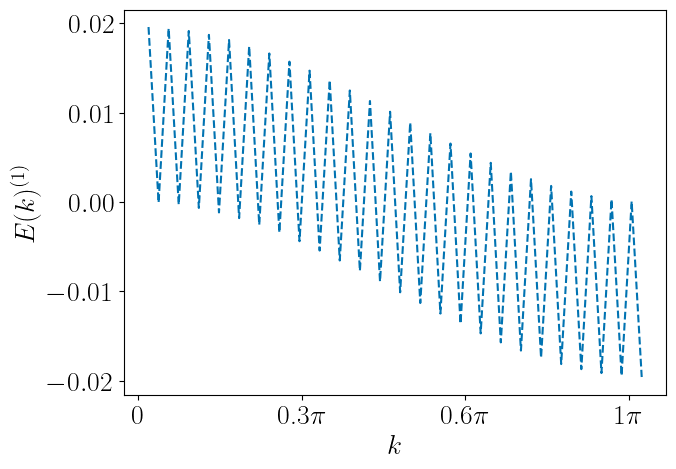

In [102]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

# First order corrections
e1 = (1/(L_qpc+1))*np.sin(bond_index*k_single_band)*np.sin(bond_index*k_single_band+k_single_band)

plt.plot(k_single_band, e1,linestyle="dashed")
#plt.plot(k_single_band,E1_degenpp, label="Degen")
#plt.plot(k_single_band,E1_degenpm, label="Degen")


ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda val,
                                                             pos: r'{:.0g}$\pi$'.format(val/np.pi)
                                                             if val !=0 else '0'))

#plt.legend()
plt.xlabel(r"$k$")
plt.ylabel(r"$E(k)^{(1)}$")

plt.savefig(fig_route+"E1_corr={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


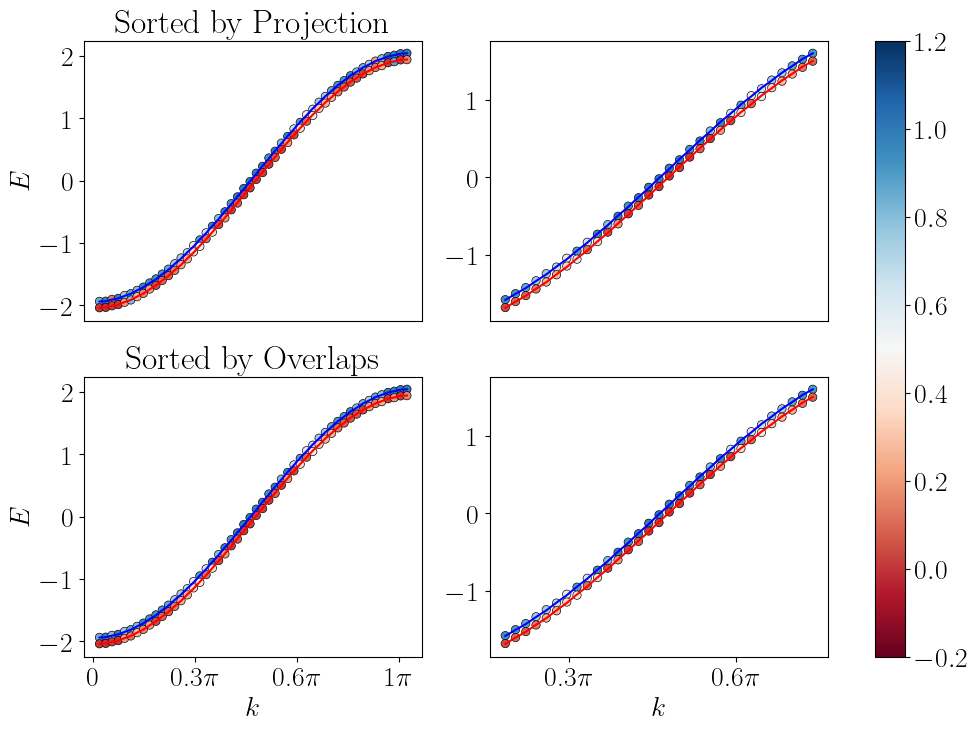

In [103]:
# first order corrections
Em = em0 + Omega*e1
Ep = ep0 + Omega*e1
Epp = ep0 + Omega*E1_degenpp
Epm = ep0 + Omega*E1_degenpm


ax = plot_2_bands_2sorts(Em, Ep, energies_m, energies_p, over_energies_m, over_energies_p, pro_colors_m, pro_colors_p,
                        over_colors_m, over_colors_p)
#ax[0,0].plot(k_single_band, Epp, color="orange")
#ax[0,0].plot(k_single_band, Epm, color="green") 
#ax[0,1].plot(k_single_band[cut1:cut2], Epp[cut1:cut2], color="orange")
#ax[0,1].plot(k_single_band[cut1:cut2], Epm[cut1:cut2], color="green")

# plt.savefig(fig_route+"first_order_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


Text(0, 0.5, '$Errors$')

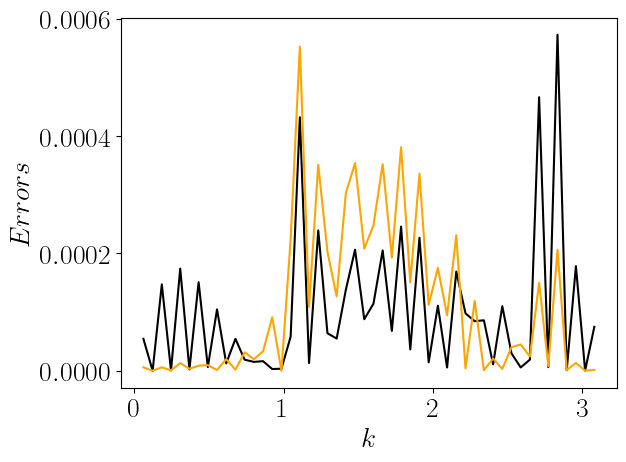

In [719]:
# plot the errors of the first correction vs zeroth order

Err0m = np.abs(energies_m - em0)**2
Err1m = np.abs(energies_m - Em)**2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")



## Second Order

Due to the normalization factor these corrections are super small nad the longer the chain the smaller they become

In [720]:
def get_second_order(krange, eta, Bond):
    # eta is +-t depemndeing on the qubit states
    E2 = []

    for k in krange:
        # remove k so the sums don't blow up
        p_range = np.asarray([x for x in krange if x != k])
        A_N = 1/(L_qpc+1)**2
    
        T1 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))) )
        T2 = A_N*(1/(2*eta))*xhi(k,k,bond_index)**2
        T3 = A_N*np.sum( (xhi(k, p_range, Bond)**2)/(-2*J[0]*(np.cos(k)-np.cos(p_range))+2*eta) )
    
        E2.append(T1 + T2 + T3) 
        
    E2 = np.asarray(E2)
    
    return E2
    

In [721]:
e2p_correction = get_second_order(k_single_band, t, bond_index)
e2m_correction = get_second_order(k_single_band, -t, bond_index)

array([[<Axes: title={'center': 'Sorted by Projection'}, ylabel='$E$'>,
        <Axes: >],
       [<Axes: title={'center': 'Sorted by Overlaps'}, xlabel='$k$', ylabel='$E$'>,
        <Axes: xlabel='$k$'>]], dtype=object)

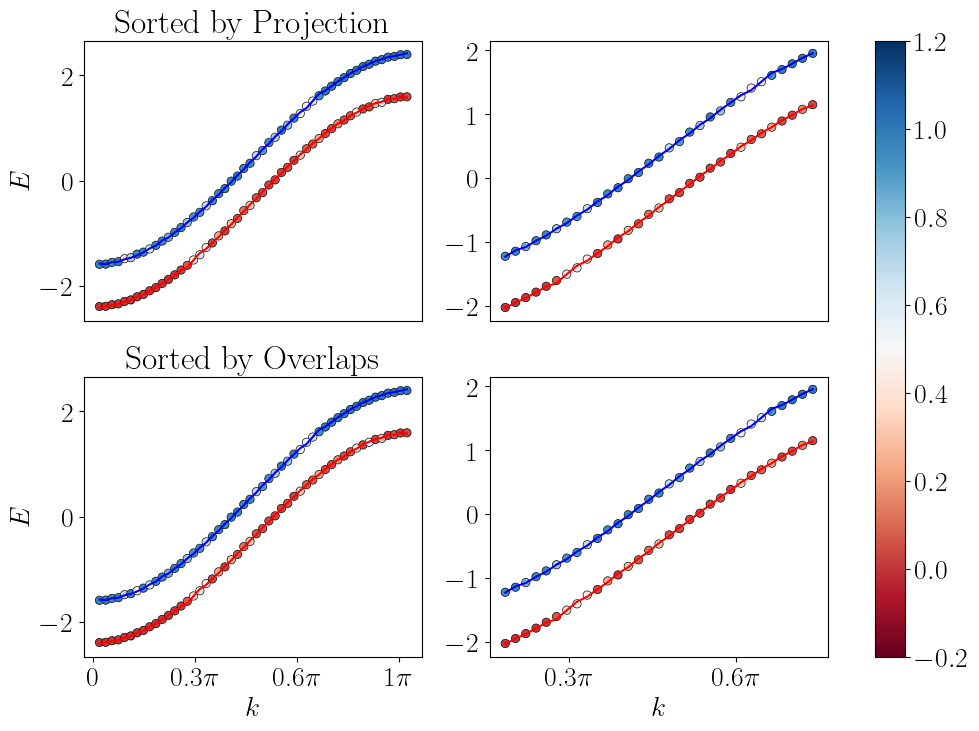

In [722]:
Ep2 = ep0 + Omega*e1 + (Omega**2)*e2p_correction
Em2 = em0 + Omega*e1 + (Omega**2)*e2m_correction

plot_2_bands_2sorts(Em2, Ep2, energies_m, energies_p, over_energies_m, over_energies_p, pro_colors_m, pro_colors_p,
                        over_colors_m, over_colors_p)
# plt.savefig(fig_route+"second_order_Lqpc={}_Omega={}_t={}.pdf".format(L_qpc, Omega,t),bbox_inches='tight')


Text(0, 0.5, '$Errors$')

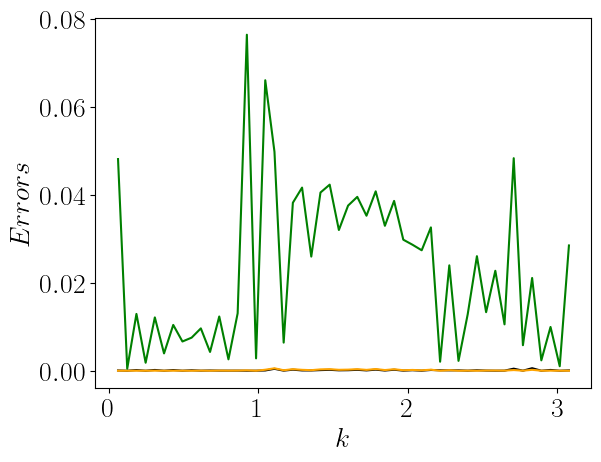

In [723]:
Err2m = np.abs(energies_m - Em2)*2

plt.plot(k_single_band,Err0m, c="black")
plt.plot(k_single_band,Err1m, c="orange")
plt.plot(k_single_band,Err2m, c="green")

plt.xlabel(r"$k$")
plt.ylabel(r"$Errors$")

## Testing where the degeneracies appear

There is a competition between two terms when we look at the perturbative corredctions between the states: the typical one from tight-binding model that is degenerate at the edges of the band, and a new one that mixes up the bands and seems to be dominating around the pi/2. _I think this second term is the one that is making both bands hiridize towards the middle_.

**If we taylor expand the denominator of the perturbative corrections around some point in k, we will see thatm, the condition for the perturbative series being well behaved is that $t<\Delta k$. Since $\Delta k$ is not constant, then the degeneracies will appear at different point of the band, depending on where we place $t$. This is the reason why the hibridization term wins sometimes** 

Text(0.5, 0, '$k$')

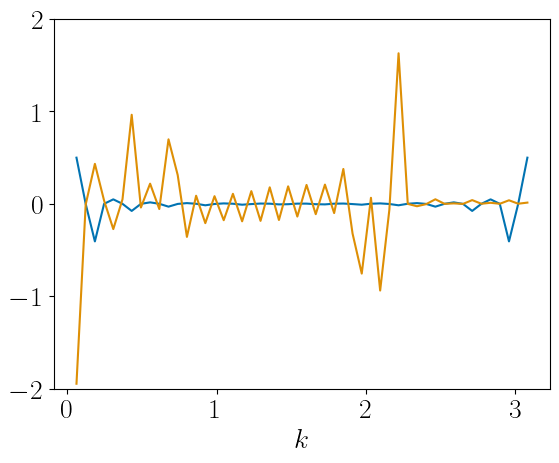

In [724]:
# usual tight-binding degen term
P1_list = []
# New band mixing term
P2_list = []
krange = k_single_band
Bond = bond_index

for k in krange:
    # remove k so the sums don't blow up
    p_range = np.asarray([x for x in krange if x != k])
    A_N = 1/(L_qpc+1)

    p1 = Omega*A_N*np.sum( xhi(k, p_range, Bond)/(-2*J[0]*(np.cos(k)-np.cos(p_range))))
    P1_list.append(p1)

    p2 = Omega*A_N*np.sum( xhi(k, p_range, Bond)/(2*t-2*J[0]*(np.cos(k)-np.cos(p_range))))
    P2_list.append(p2)
    

plt.plot(k_single_band, P1_list, label="P1")
plt.plot(k_single_band, P2_list, label="P2")
plt.ylim(-2,2)
plt.xlabel(r"$k$")



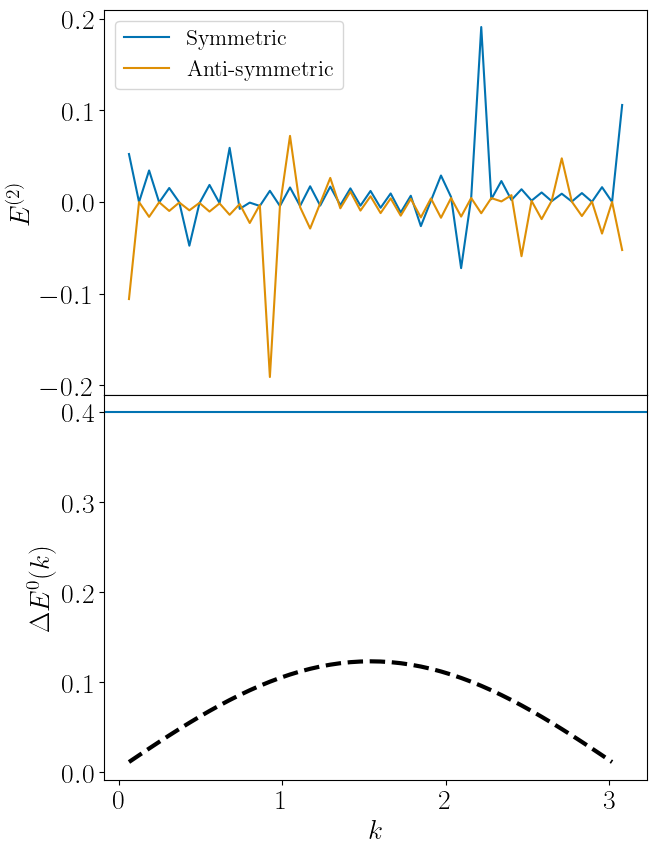

In [725]:
fig, ax = plt.subplots(2,1,figsize=(bwidth,2*bheight), sharex= True)

ax[0].plot(k_single_band, e2p_correction, label="Symmetric")
ax[0].plot(k_single_band, e2m_correction, label="Anti-symmetric")
# Plot where the degeneracies will be at
ax[0].set_ylabel(r"$E^{(2)}$")
ax[0].legend()

ax[1].plot(k_single_band[:-1], np.diff(ep0) , c="black",linewidth=3, linestyle="dashed",)
ax[1].axhline(t)
ax[1].set_ylabel(r"$\Delta E^{0} (k)$")
ax[1].set_xlabel(r"$k$")

fig.subplots_adjust( hspace=0.)


# Perturbation to the entropy
Comparing with our numerics

In [735]:
data_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_df = data_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_df))
print(data_df.columns)
data_df.head()

Number of data points: 1398
Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi,dd_density_hit
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796,1.000000
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688,0.030646
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600,0.547722
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299,0.883334
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548,0.243214


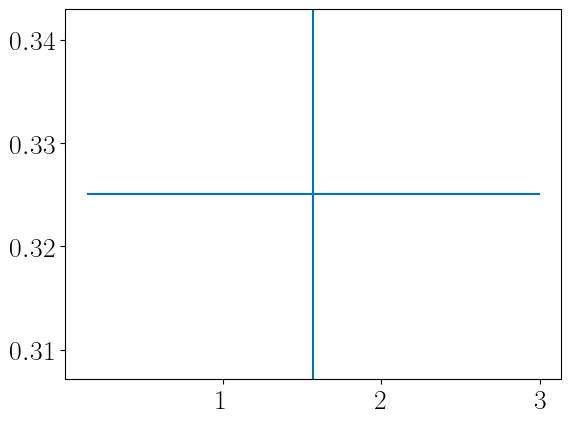

In [969]:
Delta = 2.0
bond_index = 7
Om_ = 0.0
N=20
k_range = np.arange(1,N+1)*np.pi/(N+1)

t=0.1
    
# qubit probas 
betam = np.sqrt(0.9)
betap = np.sqrt(0.1)
Svn_list = []
Ak0_list = []

for i in range(0,len(k_range)):
    k0 = k_range[i]
    # momentum distribution
    ak = np.exp(-((k_range - k0)**2)*Delta**2)
    ak = ak/np.sum(ak)
    # Gaussian  average over the xhi functions
    Ak0 = np.sum( ak*xhi(k_range,k_range,bond_index) )

    # qubit density matrix eigenvalues
    coeff_ = np.sqrt( ((Ak0*Om_)**2 + (t+t*N)**2)*(betam**2 - betap**2)**2 )/(2*t*(N+1))
    
    eig1 = 1/2 + coeff_
    eig2 = 1/2 - coeff_

    Svn_list.append(- eig1*np.log(eig1) - eig2*np.log(eig2))
    Ak0_list.append(Ak0)

plt.plot(k_range,Svn_list)
plt.axvline(np.pi/2)

In [976]:
eig1 = 0.9
eig2 = 0.1
print(eig1 + eig2)
- eig1*np.log(eig1) - eig2*np.log(eig2)

1.0


0.3250829733914482

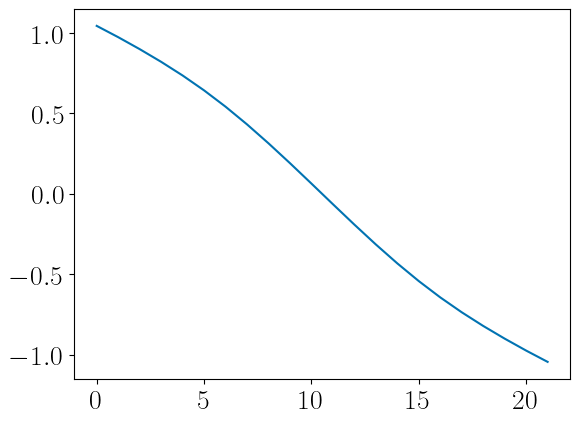

In [956]:
plt.plot(Ak0_list)

Using the proper DFT?

In [947]:
k0=np.pi/2
x_range = np.arange(1,N+1)
a_x = np.exp(-(0.5/(Delta**2))*(x_range-bond_index)**2)*np.exp(1j*k0*(x_range-bond_index))
ak_s = np.fft.fft(a_x)
ak = np.abs(ak_s)**2
ak = ak / np.sum(ak)


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

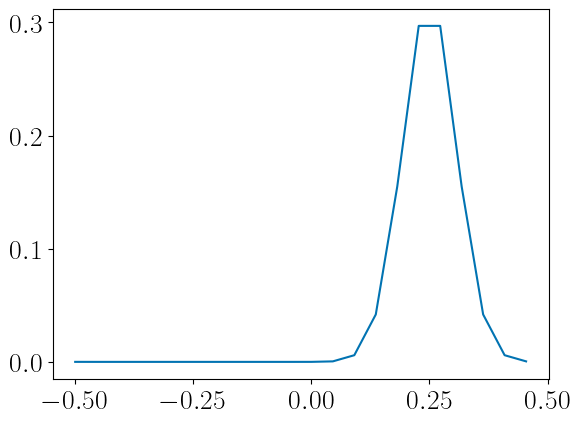

In [948]:
freqs = np.fft.fftfreq(N, d=(x_range[1] - x_range[0]))

# Shift for visualization
fft_shifted = np.fft.fftshift(ak)
freqs_shifted = np.fft.fftshift(freqs)

plt.plot(freqs_shifted, fft_shifted)
x_range

# Scattering and Spread

Comparing the numerics with our mathematics

In [728]:
data_df = pd.read_csv('../data/exp_pro/exploration_data_L=21.csv')
data_df.rename(columns={"band_width": "x_spread"}, inplace=True)
data_df = data_df.drop(["Unnamed: 0"], axis=1).drop_duplicates()

print("Number of data points:", len(data_df))
print(data_df.columns)
data_df.head()


Number of data points: 1398
Index(['L_qpc', 'max_time', 'tsteps', 'bond_index', 'x_spread', 'k0',
       'J_prime', 't', 'Omega', 'vg', 'time_at_bond', 'bond_fit_error',
       'time_f_free', 'time_f_int', 'xf_avg_free', 'xf_avg_int',
       'Transmision_tot', 'Transmission_k0', 'r_density_free', 'r_density_int',
       'last_density_free', 'last_density_int', 'last_density_max',
       'time_last_density_max', 'bond_density_max', 'min_purity',
       'max_VN_entropy', 'entanglement_timeskip', 'T_mean', 'ddot0', 'kick',
       'theta_f', 'phi_f', 'delta_phi', 'dd_density_hit'],
      dtype='object')


,L_qpc,max_time,tsteps,bond_index,x_spread,k0,J_prime,t,Omega,vg,...,min_purity,max_VN_entropy,entanglement_timeskip,T_mean,ddot0,kick,theta_f,phi_f,delta_phi,dd_density_hit
0,21,18.0,400,7,0.5,0.392699,1.0,0.0,0.40,0.765367,...,1.000000,8.992806e-15,10,0.951081,fixed,0.564233,2.107342e-08,0.000000,1.570796,1.000000
1,21,18.0,400,7,0.5,0.981748,1.0,0.4,0.01,1.662939,...,0.999962,2.238491e-04,10,0.802858,fixed,0.012193,2.895775e+00,1.535108,0.035688,0.030646
2,21,18.0,400,7,2.0,0.392699,1.0,0.2,0.50,0.765367,...,0.902862,2.020031e-01,10,0.827560,fixed,0.834754,1.550818e+00,-1.090803,2.661600,0.547722
3,21,18.0,400,7,0.5,0.981748,1.0,0.1,0.05,1.662939,...,0.998104,7.552377e-03,10,0.801953,fixed,0.060610,2.291796e+00,1.488497,0.082299,0.883334
4,21,18.0,400,7,2.0,0.392699,1.0,0.3,0.10,0.765367,...,0.994725,1.833645e-02,10,0.872464,fixed,0.171816,6.310212e-01,1.405248,0.165548,0.243214


In [729]:
print(data_df["x_spread"].unique())
print(data_df["t"].unique())
Delta = 2.0
# here the actual spatial variance (spread) of the wavepacket is defined as, accordin
# to shankar sqrt(2) Delta


[0.5 2. ]
[0.   0.4  0.2  0.1  0.3  0.01 0.8  0.5  0.7  0.6  0.9  0.05 1.  ]


### Comparing the measurement time as the FWHM

In [730]:
bindex = data_df["bond_index"].unique()[0]
vg_list = sorted(data_df.vg.unique())
k_list = np.linspace(np.pi/8,np.pi/2,100)

# The measurement time is the FWHM of the wavepacket
# so we have to estimate how much the wavepacket has spread at the time where it hits the bond
Deltax_f = np.sqrt( 0.5*Delta**2*(1+(bindex**2/Delta**4)*np.tan(k_list)**(-2)) )
T_meassure = 2*np.sqrt(2*np.log(2))*Deltax_f/(2*J[0]*np.sin(k_list))


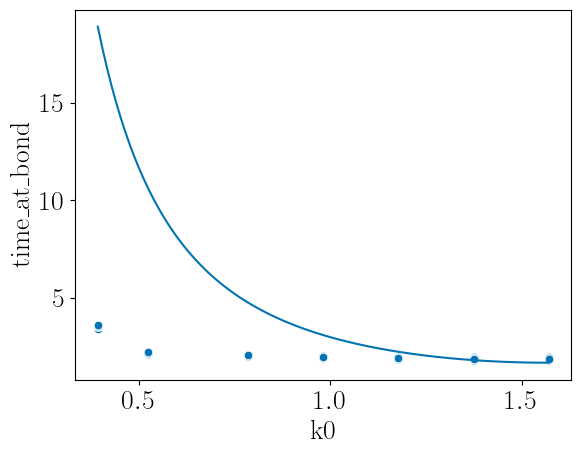

In [731]:
curr_df = data_df[ (data_df["x_spread"]==2.0) ]
sns.scatterplot(data=curr_df, x="k0", y="time_at_bond")
plt.plot(k_list, T_meassure)


### Looking at the pre measurement gained phase for specific cases

<Axes: xlabel='k0', ylabel='delta_phi'>

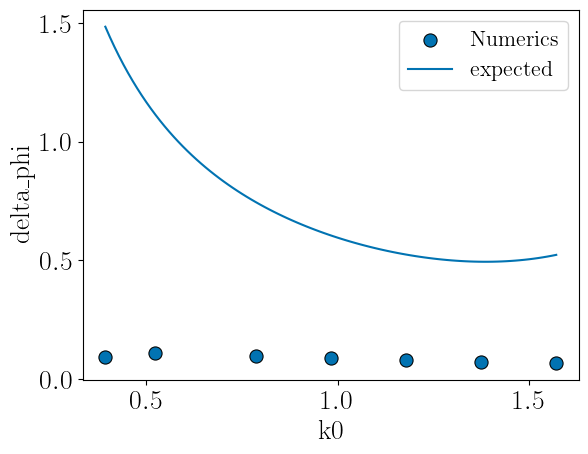

In [732]:
om_ = 0.1
bw_ = 2.0
t_ = 0.05

cond = (data_df["t"] == t_) & (data_df["x_spread"] == bw_) & (data_df["Omega"] == om_)
phi_theo = 2*om_*k_list*T_meassure

sns.scatterplot(data = data_df[cond], x="k0" ,y="delta_phi",edgecolor='black' ,s=90, label="Numerics")
sns.lineplot(x=k_list,y=phi_theo, label="expected")

### Comparing the purity

In [733]:
R = np.exp(-(om_*T_meassure/Delta)**2)

In [734]:
print(theta_)

Purity = 0.5*( 1+ (R**2)*(np.sin(theta_)**2) + np.cos(theta_)**2 )

plt.plot(k_list, Purity)
sns.scatterplot(data = data_df[cond], x="k0" ,y="min_purity",edgecolor='black' ,s=90, label="Numerics")


NameError: name 'theta_' is not defined